# Исследование оттока клиентов телеком-компании

In [3]:
pip install --upgrade jupyter

Описание проекта: Оператор связи «*****» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. 

# Описание услуг

Оператор предоставляет два основных типа услуг:

1)Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

2)Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);

- Выделенная линия технической поддержки (TechSupport);

- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);

- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;

- personal_new.csv — персональные данные клиента;

- internet_new.csv — информация об интернет-услугах;

- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

1)Таблица contract
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.


2)Таблица personal
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.


3)Таблица internet
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.


4)Таблица phone
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

# Цель исследования

Обучить модель определять отток клиентов, затем на основе предсказаний делать клиентам специальные предложения чтобы удержать клиентскую базу. По окончанию проекта нам необходимо обучить модель чтобы метрика AUC-ROC была больше или равна 0,85.

# План выполнения задачи по уменьшению оттока клиентов:

1) Написать описание и цель проекта,выбрать метрику и ее нижний порог.

2) Загрузить данные.

3) Провести анализ данных.

4) Предобработать данные. Найти аномалия, заменить по возможности их. Найти и заменить пропуски. Проверить типы данных.

5) Подготовить данные:

 - Найти целевой признак.
 
 - Объеденить данные.
 
6) Предобработать и подготовить данные к обучению модели:

 - Посмотреть есть ли дисбаланс классов.
 
 - StandartScaler.
 
 - OHE enconder.
 
7) Обучить модель:

 - Взять несколько моделей и провести перебор гиперпараметров.
 
 - Выбрать лучшую модель.
 
8) Проверить модель на тестовой выборке:

 - Предикт на лучшей модели.
 
 - Проверка выбраной мертрики на тестовых данных.

9) Выполнить анализ лучшей модели:

- Определить важность признаков.

- Вывести матрицу ошибок.
 
10) Сделать общий вывод по всему исследованию.


In [1]:
!pip install scikit-learn==1.1.3

In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import phik

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer    
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from phik.report import plot_correlation_matrix
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

RANDOM = 140823

pd.set_option('display.max_columns', 100)
sns.set()

## Загрузка Данных

In [5]:
df_contract = pd.read_csv('/datasets//contract_new.csv')
df_personal = pd.read_csv('/datasets/personal_new.csv')
df_internet = pd.read_csv('/datasets/internet_new.csv')
df_phone = pd.read_csv('/datasets/phone_new.csv')

In [6]:
display(df_contract.head(10), df_contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


None

- В данных отсутствуют пропуски.
- BeginDate и EndDate должны иметь формат даты. EndDate если клиент ушел отмечена дата, если нет указано No.
- Бинарные признак перевести в (0, 1), в категориальных определить количество категорий и ранжировать.
- Данные представлены на 01-02-2020. Значит для тех кто не ушел, No в EndDate заменим на эту дату
- TotalCharges перевести в int.

In [7]:
display(df_personal.head(10), df_personal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


None

- В данных отсутствуют пропуски.
- Бинарные признак перевести в (0, 1)

In [8]:
display(df_internet.head(10), df_internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


None

- Данные не по всем клиентам. Значит интернетом пользуются не все клиенты.
- Пропусков нет
- значения бинарных признаков перевести в (0, 1)

In [9]:
display(df_phone.head(10), df_phone.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


None

- Бинарный признак перевести в (0, 1)

# Вывод:
В предоставленных данных нет пропусков. Все бинарные признаки необходимо заменить на (0, 1). Стоит также в некоторых столбцах изменить тип данных. Все названия столбцов необходимо привести к змеиному регистру.

## Предобработка данных

Объеденим 4 датасета в один по столбцу customerID.

In [10]:
df = df_contract.merge(df_personal, on = 'customerID', how='left').merge(df_internet, on = 'customerID', how='left').merge(df_phone, on = 'customerID', how='left')

In [11]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Проверим на наличее дубликатов.

In [12]:
print('Количество дубликатов', df.duplicated().sum())

Количество дубликатов 0


Приведем название столбцов к нижнему регистру и к snake case.

In [13]:
df.columns = df.columns.str.lower()

df.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
              'payment_method', 'monthly_charges', 'total_charges', 'gender',
              'senior_citizen', 'partner', 'dependents','internet_service',
              'online_security', 'online_backup', 'device_protection',
              'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

In [14]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Проверим пропуски

In [15]:
df.isna().mean()

customer_id          0.000000
begin_date           0.000000
end_date             0.000000
type                 0.000000
paperless_billing    0.000000
payment_method       0.000000
monthly_charges      0.000000
total_charges        0.000000
gender               0.000000
senior_citizen       0.000000
partner              0.000000
dependents           0.000000
internet_service     0.216669
online_security      0.216669
online_backup        0.216669
device_protection    0.216669
tech_support         0.216669
streaming_tv         0.216669
streaming_movies     0.216669
multiple_lines       0.096834
dtype: float64

Заполним пропуски

In [16]:
df['internet_service'] = df['internet_service'].fillna('no_information')

In [17]:
for column in ['online_security', 'online_backup', 'device_protection',
               'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']:
    df[column].fillna('no_info', inplace=True)

In [18]:
display(df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

None

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_info
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_info
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Изменим ти данных у столбца 'total_charges' c object на float64.    

In [19]:
(df['total_charges'] == ' ').value_counts()

False    7032
True       11
Name: total_charges, dtype: int64

In [20]:
df = df.loc[df['total_charges'] !=' ']
df['total_charges'] = df['total_charges'].astype('float64')

Изменим тип данных begin_date на datetime

In [21]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format = '%Y-%m-%d')

Данные представлены на 01-02-2020. Для тех кто не ушел, No в EndDate заменим на эту дату

In [22]:
df.loc[df['end_date'] == 'No', 'end_date'] = '2020-02-01'

Изменим тип данных end_date на datetime

In [23]:
df['end_date'] = pd.to_datetime(df['end_date'],format='%Y.%m.%d')
df.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_info
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_info
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Создадим целевой признак.

In [24]:
df['churn'] = 'client_left'
df.loc[df['end_date'] == '2020-02-01', 'churn'] = 'stayed_client'

Посмотри дисбаланс классов

In [25]:
df['churn'].value_counts(normalize=True)

stayed_client    0.84343
client_left      0.15657
Name: churn, dtype: float64

Создадим столбец duration с продолжительностью контракта.

In [26]:
df['duration'] = (df['end_date'] - df['begin_date']).dt.days

Создадим новый столбец который покажет увлеченность клиента исходя из подключенных сервисов.

In [27]:
df['services'] = 'all_services '
df.loc[df['multiple_lines'] == 'no_info', 'services'] = 'internet_services' 
df.loc[df['internet_service'] == 'no_info','services'] = 'phone_services' 

Еще раз взглянем на таблицу и на пропуски в ней

In [28]:
display(df.head(), df.isna().mean())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,duration,services
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_info,stayed_client,31,internet_services
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,stayed_client,1036,all_services
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,stayed_client,123,all_services
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_info,stayed_client,1371,internet_services
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,stayed_client,153,all_services


customer_id          0.0
begin_date           0.0
end_date             0.0
type                 0.0
paperless_billing    0.0
payment_method       0.0
monthly_charges      0.0
total_charges        0.0
gender               0.0
senior_citizen       0.0
partner              0.0
dependents           0.0
internet_service     0.0
online_security      0.0
online_backup        0.0
device_protection    0.0
tech_support         0.0
streaming_tv         0.0
streaming_movies     0.0
multiple_lines       0.0
churn                0.0
duration             0.0
services             0.0
dtype: float64

# Вывод:
- объединили четыре датасета в один датасет по customerID.

- заполнили пропущенные значения.

- приводили название столбцов к нижнему регистру.

- привели название столбцов к snake case.

- поменяли у некоторых столбцов типы данных.

- добавили новые столбцы:
  - churn - клиент ушел или нет (целевой признак).
  - duration - сколько в днях дейсвует договор.
  - services - какое количество сервисов использует клиент.

## Анализ данных

Посмотрим нелинейную зависимость между признаками при помощи корреляции Фика.

In [29]:
phik_df = df.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'duration']


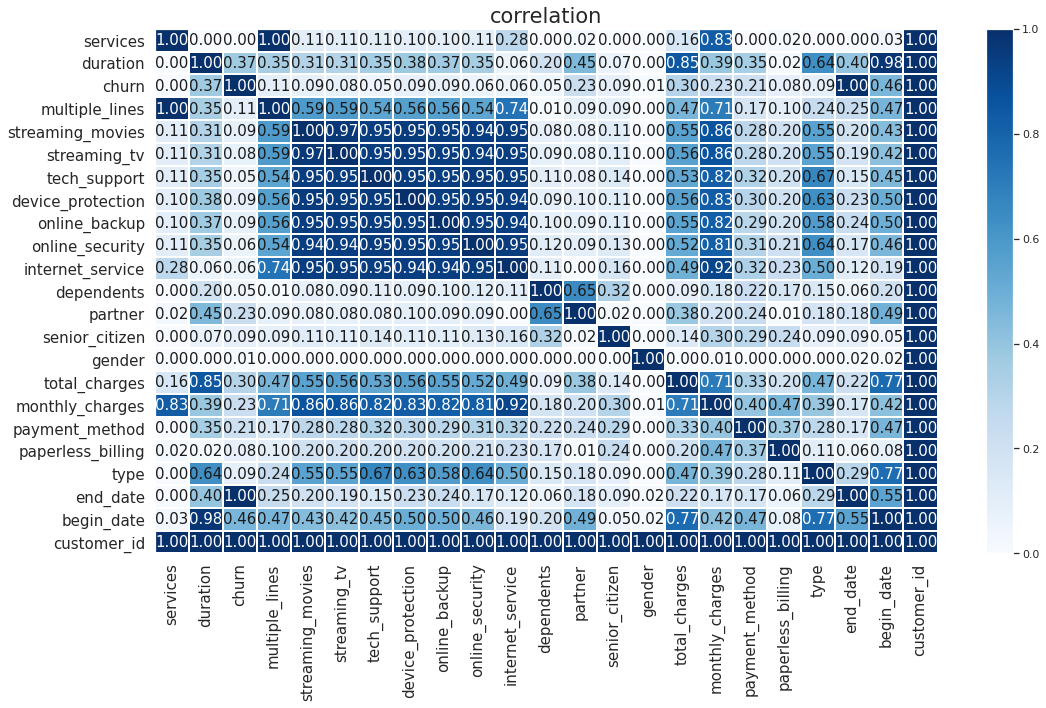

In [30]:
plot_correlation_matrix(phik_df.values, 
                        x_labels=phik_df.columns, 
                        y_labels=phik_df.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title="correlation", 
                        fontsize_factor=1.5, 
                        figsize=(16, 10))
plt.tight_layout()

Из матрицы корреляции мы можем заметить:
- Сильную зависимость между total_charges b monthly_charges корреляция Фика 0.71
- total_charges завист от подключенных услуг у абонента.
- Наличие dependents зависит от partner.
- Сильная зависимость есть у подключенных услкг корреляция Фика больше 0.9 следовательно либо пользователь подключает все и сразу либо из-за заинтересованности он подключает дополнительно остальные услуги.

Посмотрим на важность признаков в датасете.

In [31]:
phik_df['churn'].sort_values(ascending=False)

customer_id          1.000000
end_date             1.000000
churn                1.000000
begin_date           0.461977
duration             0.374101
total_charges        0.303758
partner              0.227597
monthly_charges      0.225823
payment_method       0.214300
multiple_lines       0.105172
type                 0.094622
online_backup        0.089771
streaming_movies     0.086371
senior_citizen       0.085708
device_protection    0.085665
paperless_billing    0.082789
streaming_tv         0.078554
online_security      0.058630
internet_service     0.056279
tech_support         0.051442
dependents           0.048710
gender               0.008800
services             0.000000
Name: churn, dtype: float64

На отток клиентов сильно влияют:
- payment_method - способ оплаты
- monthly_charges - Ежемесячная оплата
- paperless_billing - способ получения счета
- total_charges - общая сумма оплаты
- type - тип договора

Посмотрим на числовые признаки

In [32]:
df[['monthly_charges','total_charges','duration']].describe()

,monthly_charges,total_charges,duration
count,7032.000000,7032.000000,7032.000000
mean,64.798208,2118.621822,899.961320
std,30.085974,2112.736199,682.738777
min,18.250000,19.050000,28.000000
25%,35.587500,439.745000,276.000000
50%,70.350000,1345.275000,761.000000
75%,89.862500,3239.317500,1461.000000
max,118.750000,9221.380000,2314.000000


- total_charges сильное различие между медианой и среднем значением.

,monthly_charges,total_charges,duration
monthly_charges,1.000000,0.630297,0.218955
total_charges,0.630297,1.000000,0.821442
duration,0.218955,0.821442,1.000000


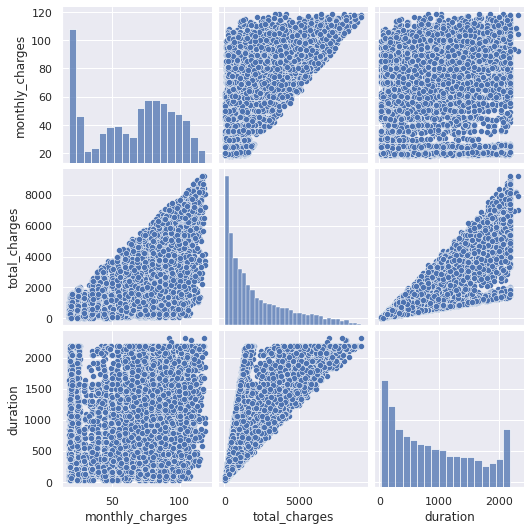

In [33]:
sns.pairplot(df[['monthly_charges', 'total_charges', 'duration']])
df[['monthly_charges', 'total_charges', 'duration']].corr().style.background_gradient()

- сильная зависимость между total_charges и duration значение корреляции Пирсона 0.82.
- сильнаяя зависимость между total_charges и monthly_charges значение корреляции Пирсона 0.63.   

Посмотрим графики зависимости оттока клиентов из-за разных факторов. Уход клиентов для каждого типа договоров.

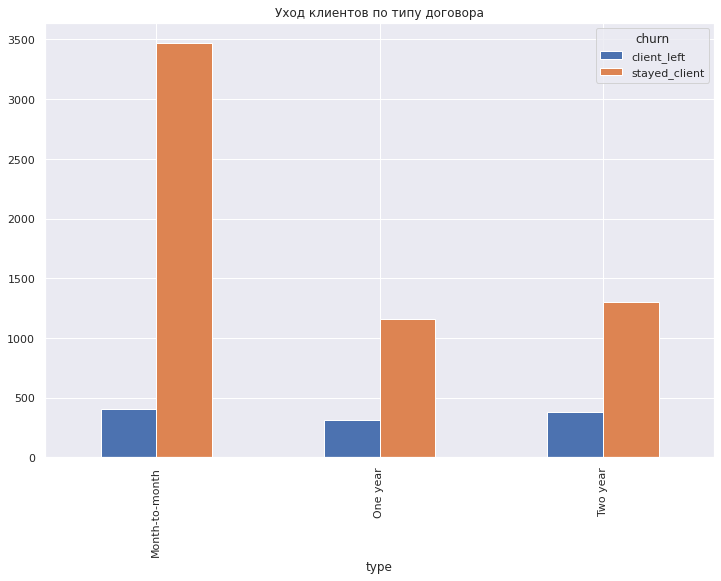

In [34]:
(
   df
    .pivot_table(index = 'type', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(12, 8), title = 'Уход клиентов по типу договора')
)
None

- Большой отток клиентов которые имеют ежемесячный договор, скорее всего это новые клиенты которые пришли по рекламе или же сами и им просто не понравилось.

Уход клиентов исходя из-за вида получения счета.

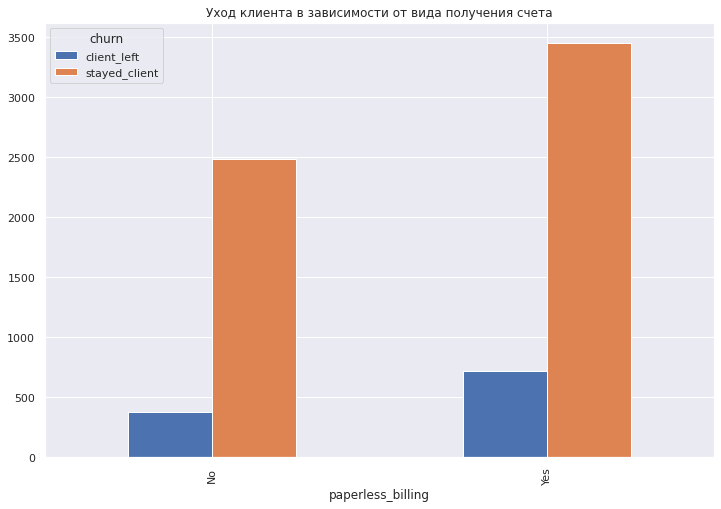

In [35]:
(
    df
    .pivot_table(index = 'paperless_billing', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(12, 8),  title = 'Уход клиента в зависимости от вида получения счета')
)
None

- Больше всего уходят клиенты которые получают электронные счета.

Уход клиента исходя из способа оплаты.

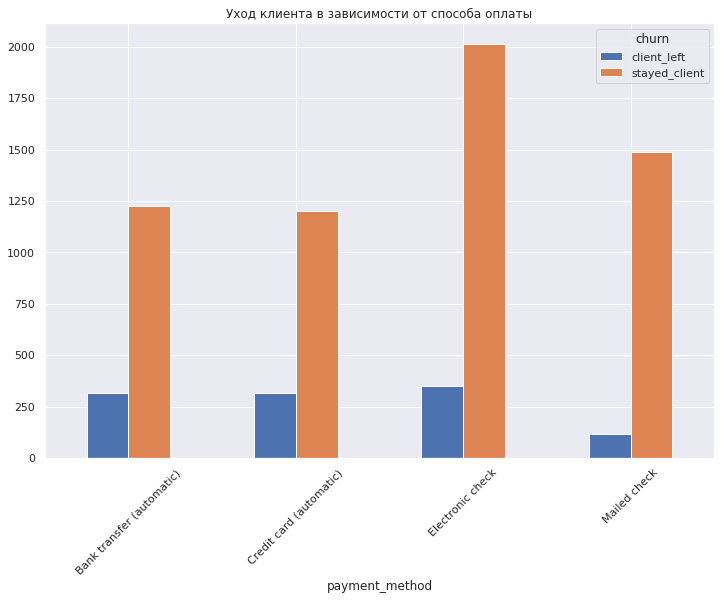

In [36]:
(
    df
    .pivot_table(index = 'payment_method', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(12, 8), title = 'Уход клиента в зависимости от способа оплаты',rot=45)
)
None

- Больше всего уходят клиенты получающие электронные чеки.

Уход клиента в зависимости от возраста.

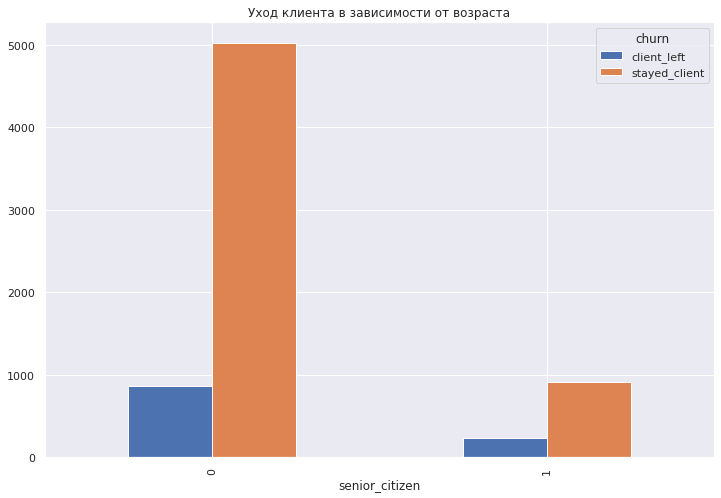

In [37]:
(    
    df
    .pivot_table(index = 'senior_citizen', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(12, 8), title = 'Уход клиента в зависимости от возраста')
)
None

- Пожилые клиенты уходят больше всего.

Уход клиентов в зависимости от пола.

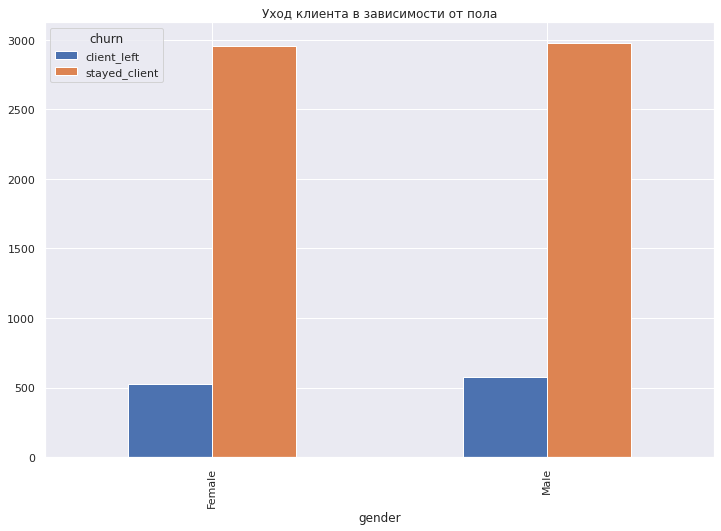

In [38]:
(
    df
    .pivot_table(index = 'gender', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(12, 8),  title = 'Уход клиента в зависимости от пола')
)
None

- Видно что на уход клиента не сильно влияет пол покупателя.

Уход клиентов в зависимости от семейного положения.

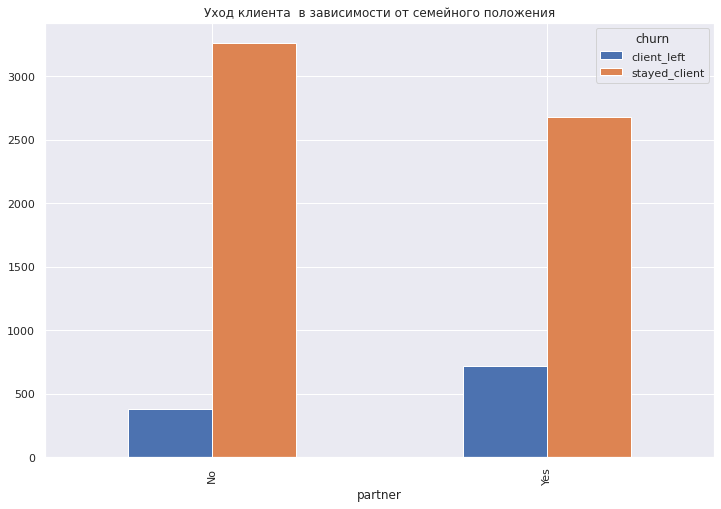

In [39]:
(
   df
    .pivot_table(index = 'partner', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(12, 8), title = 'Уход клиента  в зависимости от семейного положения')
)
None

- Видно что чаще всего уходят клиенты не состоящие в браке

Уход клиента в зависимости от наличие ребенка.

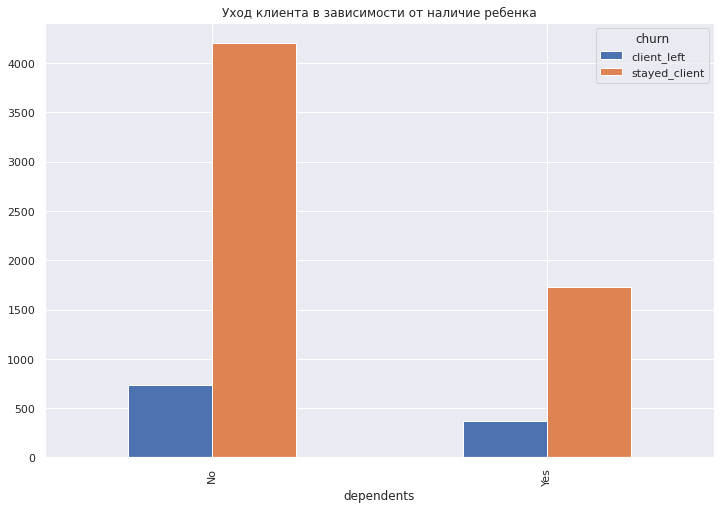

In [40]:
(
   df
    .pivot_table(index = 'dependents', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(12, 8), title = 'Уход клиента в зависимости от наличие ребенка')
)   
None

- Видно что чаще всего уходят люди не имеющие детей.

Уход клиента в зависимости от интернет-сервиса.

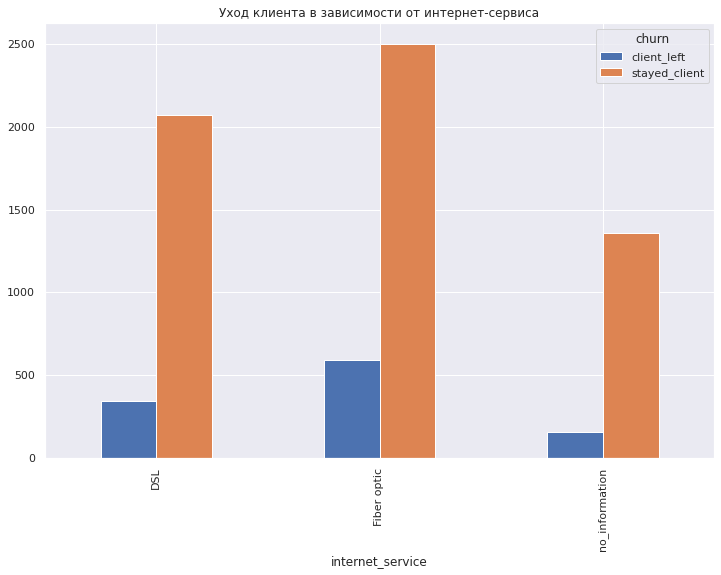

In [41]:
(
   df
    .pivot_table(index = 'internet_service', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(12, 8), title = 'Уход клиента в зависимости от интернет-сервиса')
)
None

- Видно что чаще всего уходят клиенты fiber optic.

Уход клиента в зависимости от услуги Техподдержка.

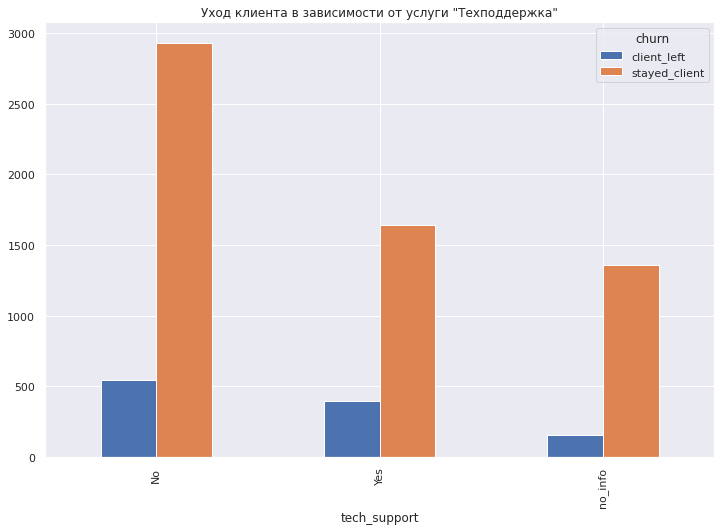

In [42]:
(
   df
    .pivot_table(index = 'tech_support', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(12, 8), title = 'Уход клиента в зависимости от услуги "Техподдержка"')
)
None

- Как мы видем в целом клиентв устраивает услуга техподдержки.

Уход клиента в зависимости от услуги Каталог фильмов.

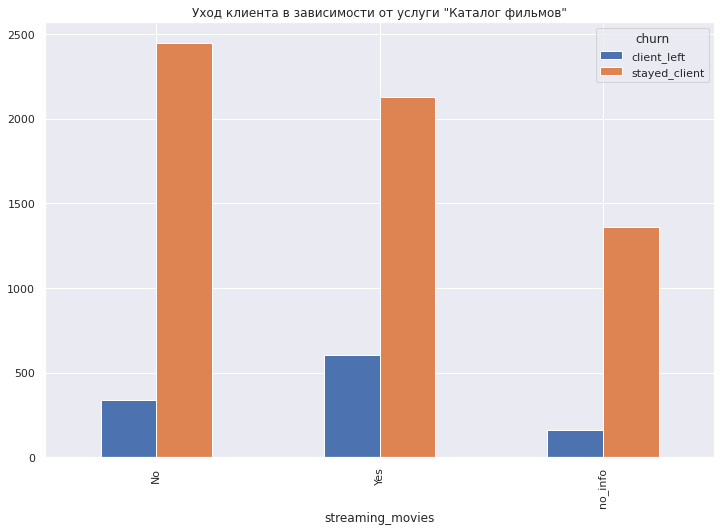

In [43]:
(
   df
    .pivot_table(index = 'streaming_movies', columns='churn',  values = 'customer_id', aggfunc = 'count')
    .plot
    .bar(figsize =(12, 8), title = 'Уход клиента в зависимости от услуги "Каталог фильмов"')
)
None

- Клиентов не совсем устраивает каталог фильмов.

Построим график чтобы посмотреть на прибль по типу договора.

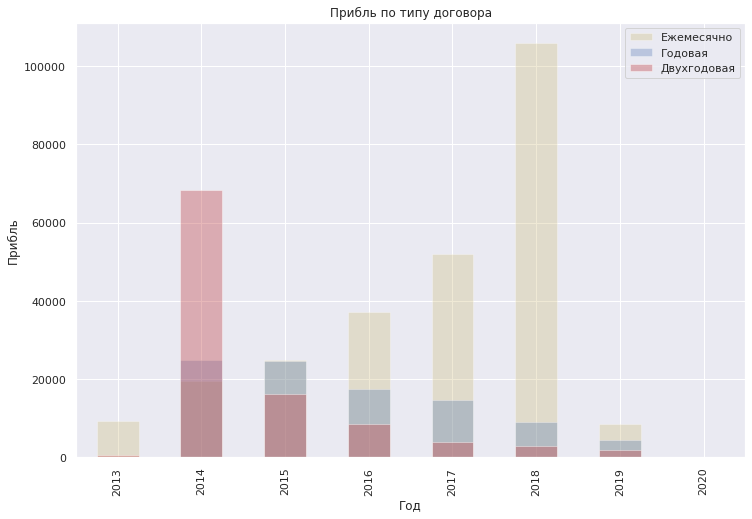

In [44]:
df_month=(df
     .query('type=="Month-to-month"')
     .pivot_table(index=df['begin_date'].dt.year,values='monthly_charges', aggfunc='sum')
     .plot(y='monthly_charges',figsize=(12,8),kind='bar',label='Ежемесячно', alpha=0.3, color='y')
)
df_one_year=(df
     .query('type=="One year"')
     .pivot_table(index=df['begin_date'].dt.year,values='monthly_charges', aggfunc='sum')
     .plot(y='monthly_charges',figsize=(12,8),kind='bar',label='Годовая',color='b',alpha=0.3, ax=df_month)
)

df_two_year=(df
     .query('type=="Two year"')
     .pivot_table(index=df['begin_date'].dt.year,values='monthly_charges', aggfunc='sum')
     .plot(y='monthly_charges',figsize=(12,8),kind='bar',label='Двухгодовая',color='r',alpha=0.4, ax=df_one_year)
)
plt.title('Прибль по типу договора')
plt.xlabel('Год')
plt.ylabel('Прибль')
None

Из графика видно:
- Пик прибыли по типу договора на 2 года был в 2014 году, затем пошло на спад.
- Пик прибыли по типу договора на ежемесячные основе в 2018 году.
- В целом спад приходится на 2019 год, возможно из-за большого оттока клиентов.

Подготовим целевой признак, изменим тип данных и присвоим для client_left==1,а для stayed_client==0. Так же удалим лишнии столбцы.

In [45]:
df.loc[df['churn'] == 'client_left', 'churn'] = 1
df.loc[df['churn'] == 'stayed_client', 'churn'] = 0
df['churn'] = df['churn'].astype('int')

In [46]:
df = df.drop([ 'begin_date', 'end_date', 'customer_id', 'services'], axis=1)

In [47]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,duration
0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_info,0,31
1,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_info,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


# Вывод:
- Сильную зависимость между total_charges b monthly_charges корреляция Фика 0.71
- total_charges завист от подключенных услуг у абонента.
- Наличие dependents зависит от partner.
- Сильная зависимость есть у подключенных услкг корреляция Фика больше 0.9 следовательно либо пользователь подключает все и сразу либо из-за заинтересованности он подключает дополнительно остальные услуги.
- сильная зависимость между total_charges и duration значение корреляции Пирсона 0.82.
- сильнаяя зависимость между total_charges и monthly_charges значение корреляции Пирсона 0.63.
- Большой отток клиентов которые имеют ежемесячный договор, скорее всего это новые клиенты которые пришли по рекламе или же сами и им просто не понравилось
- Пик прибыли по типу договора на 2 года был в 2014 году, затем пошло на спад.
- Пик прибыли по типу договора на ежемесячные основе в 2018 году.
- Больше всего уходят клиенты получающие электронные чеки.
- Подготовили целевой признак.
- Удалили лишнии столбцы.

На отток клиентов сильно влияют:

- payment_method - способ оплаты
- monthly_charges - Ежемесячная оплата
- paperless_billing - способ получения счета
- total_charges - общая сумма оплаты
- type - тип договора

## Обучение моделей

In [48]:
features = df.drop(['churn'], axis=1)
target = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM
)


In [49]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [50]:
get_data_info(X_train)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration
4723,Month-to-month,Yes,Electronic check,74.35,315.24,Male,0,No,No,Fiber optic,No,Yes,No,No,No,No,No,123
995,Month-to-month,No,Credit card (automatic),85.30,511.80,Female,0,No,No,Fiber optic,No,Yes,No,Yes,No,No,Yes,181
6116,One year,Yes,Bank transfer (automatic),73.85,3686.59,Female,0,No,No,DSL,No,Yes,Yes,Yes,Yes,No,Yes,1461
6392,Month-to-month,Yes,Electronic check,49.75,3134.25,Female,0,Yes,Yes,DSL,No,Yes,No,No,Yes,Yes,no_info,1826
3587,Month-to-month,Yes,Credit card (automatic),99.45,1318.71,Male,1,No,No,Fiber optic,No,Yes,No,No,Yes,Yes,Yes,396


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 1728 to 1475
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               5274 non-null   object 
 1   paperless_billing  5274 non-null   object 
 2   payment_method     5274 non-null   object 
 3   monthly_charges    5274 non-null   float64
 4   total_charges      5274 non-null   float64
 5   gender             5274 non-null   object 
 6   senior_citizen     5274 non-null   int64  
 7   partner            5274 non-null   object 
 8   dependents         5274 non-null   object 
 9   internet_service   5274 non-null   object 
 10  online_security    5274 non-null   object 
 11  online_backup      5274 non-null   object 
 12  device_protection  5274 non-null   object 
 13  tech_support       5274 non-null   object 
 14  streaming_tv       5274 non-null   object 
 15  streaming_movies   5274 non-null   object 
 16  multiple_lines     52

None

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration
count,5274,5274,5274,5274.000000,5274.000000,5274,5274.00000,5274,5274,5274,5274,5274,5274,5274,5274,5274,5274,5274.000000
unique,3,2,4,NaN,NaN,2,NaN,2,2,3,3,3,3,3,3,3,3,NaN
top,Month-to-month,Yes,Electronic check,NaN,NaN,Male,NaN,No,No,Fiber optic,No,No,No,No,No,No,No,NaN
freq,2861,3131,1733,NaN,NaN,2644,NaN,2717,3650,2304,2610,2280,2309,2588,2116,2090,2539,NaN
mean,NaN,NaN,NaN,64.708599,2124.453470,NaN,0.16041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,905.803185
std,NaN,NaN,NaN,30.097415,2113.053015,NaN,0.36702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,685.273123
min,NaN,NaN,NaN,18.250000,19.050000,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.000000
25%,NaN,NaN,NaN,35.562500,443.862500,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.000000
50%,NaN,NaN,NaN,70.275000,1346.600000,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,761.000000
75%,NaN,NaN,NaN,89.850000,3245.437500,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1461.000000


In [51]:
ohe_features = X_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

['type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


In [52]:
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('senior_citizen')
num_features

['monthly_charges', 'total_charges', 'duration']

In [53]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

In [54]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(X_train_lr[ohe_features])

X_train_lr[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_train_lr[ohe_features])

X_train_lr = X_train_lr.drop(ohe_features, axis=1)

scaler = StandardScaler()

X_train_lr[num_features] = scaler.fit_transform(X_train_lr[num_features])

X_train_lr.head()

,monthly_charges,total_charges,senior_citizen,duration,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_no_information,online_security_Yes,online_security_no_info,online_backup_Yes,online_backup_no_info,device_protection_Yes,device_protection_no_info,tech_support_Yes,tech_support_no_info,streaming_tv_Yes,streaming_tv_no_info,streaming_movies_Yes,streaming_movies_no_info,multiple_lines_Yes,multiple_lines_no_info
1728,0.562939,0.820458,0,0.678913,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1621,0.722436,0.508411,0,0.321358,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5554,-1.465667,-0.366681,0,1.477211,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3586,-0.821032,-0.868993,0,-1.008165,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1580,0.232314,-0.292852,1,-0.386457,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [55]:
X_test_lr[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_test_lr[ohe_features])
X_test_lr = X_test_lr.drop(ohe_features, axis=1)

X_test_lr[num_features] = scaler.transform(X_test_lr[num_features])


X_test_lr.head()

,monthly_charges,total_charges,senior_citizen,duration,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_no_information,online_security_Yes,online_security_no_info,online_backup_Yes,online_backup_no_info,device_protection_Yes,device_protection_no_info,tech_support_Yes,tech_support_no_info,streaming_tv_Yes,streaming_tv_no_info,streaming_movies_Yes,streaming_movies_no_info,multiple_lines_Yes,multiple_lines_no_info
5289,1.674435,2.317552,0,1.388187,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3717,-0.523636,-0.391548,0,-0.212787,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5023,0.185794,-0.903676,0,-1.187673,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
768,0.317047,0.492967,0,0.499406,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1918,-0.324265,-0.356345,0,-0.256569,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
X_train_lr.shape, X_test_lr.shape

((5274, 29), (1758, 29))

In [57]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [58]:
encoder = OrdinalEncoder()
encoder.fit(X_train_rf[ohe_features])

X_train_rf[encoder.get_feature_names_out()] = encoder.transform(X_train_rf[ohe_features])

X_train_rf.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration
1728,2.0,0.0,0.0,81.65,3857.96,0.0,0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1371
1621,0.0,1.0,2.0,86.45,3198.65,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1126
5554,2.0,1.0,3.0,20.60,1349.71,0.0,0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,1918
3586,0.0,0.0,3.0,40.00,288.40,1.0,0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,215
1580,1.0,0.0,0.0,71.70,1505.70,0.0,1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,641


In [59]:
X_test_rf[encoder.get_feature_names_out()] = encoder.transform(X_test_rf[ohe_features])

X_test_rf.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration
5289,1.0,1.0,3.0,115.10,7021.10,0.0,0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1857
3717,0.0,0.0,0.0,48.95,1297.17,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,760
5023,0.0,1.0,2.0,70.30,215.12,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92
768,0.0,1.0,2.0,74.25,3166.02,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1248
1918,0.0,0.0,2.0,54.95,1371.55,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,730


# модель LogisticRegression.

In [60]:
model = LogisticRegression(solver = 'liblinear', random_state=RANDOM)

penalty = ['l1', 'l2']
C = np.logspace(-3, 3, 10)
class_weight = [None, 'balanced']

params = dict(C=C, penalty=penalty, class_weight=class_weight)

lr_model = RandomizedSearchCV(estimator=model,
                              param_distributions=params, 
                              cv = 5,
                              n_iter = 10,
                              random_state = RANDOM,
                              verbose = 0, 
                              n_jobs = 1, 
                              scoring = 'roc_auc')
lr_model.fit(X_train_lr, y_train)

print('ROC_AUC для модели LogisticRegression', lr_model.best_score_)
print('Лучшие гиперпараметры:', lr_model.best_params_)

ROC_AUC для модели LogisticRegression 0.7715843534601172
Лучшие гиперпараметры: {'penalty': 'l1', 'class_weight': None, 'C': 1000.0}


Построим ROC-кривую

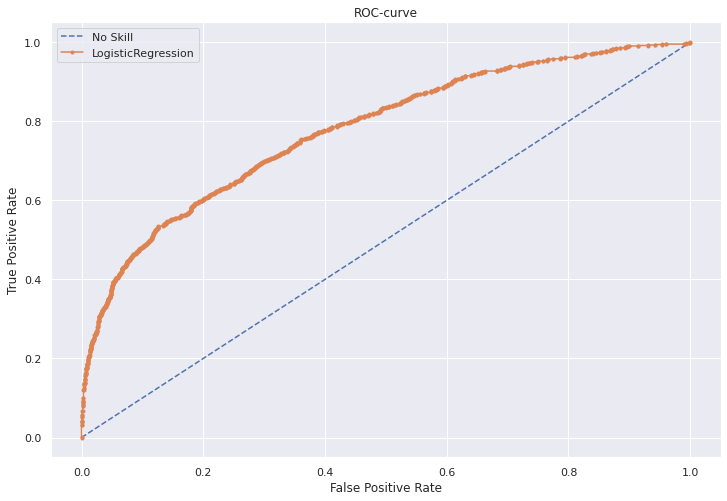

In [61]:
lr = plt.figure(figsize=(12, 8))

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, _ = roc_curve(y_train, lr_model.predict_proba(X_train_lr)[:, 1])
plt.plot(fpr, tpr, marker='.', label='LogisticRegression')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend()

plt.show()

- Лучшие гиперпараметры модели: {'penalty': 'l1', 'class_weight': None, 'C': 1000.0}
- Лучшее значение метрики 0.77

# модель RandomForestClassifier

In [62]:
model = RandomForestClassifier(random_state=RANDOM)

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)]
max_features = ['log2', 'sqrt']
criterion = ['gini', 'entropy']
class_weight = [None, 'balanced']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)]
min_samples_split = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]

params = dict(n_estimators=n_estimators, max_features=max_features, criterion=criterion, class_weight=class_weight,
              max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

rf_model = RandomizedSearchCV(estimator=model,
                              param_distributions=params, 
                              cv = 5,
                              n_iter = 10,
                              random_state = RANDOM,
                              verbose = 0, 
                              n_jobs= 1, 
                              scoring = 'roc_auc')

rf_model.fit(X_train_rf, y_train)

print('ROC_AUC для модели RandomForestClassifier', rf_model.best_score_)
print('Лучшие гиперпараметры:', rf_model.best_params_)

ROC_AUC для модели RandomForestClassifier 0.8321821141835285
Лучшие гиперпараметры: {'n_estimators': 78, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 45, 'criterion': 'gini', 'class_weight': None}


Построим ROC-кривую

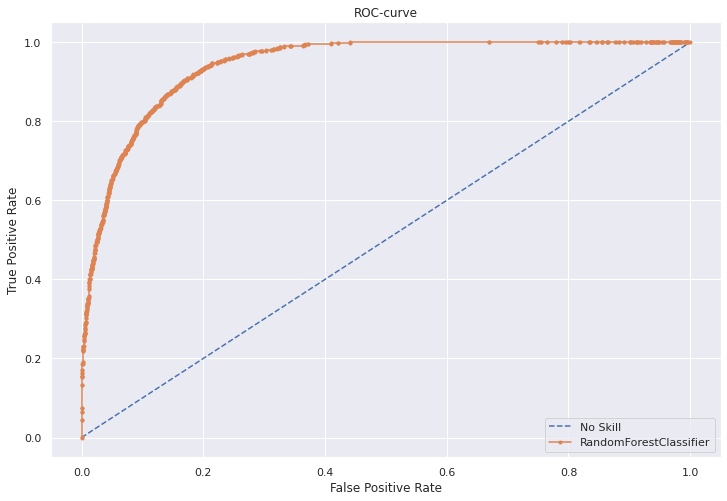

In [63]:
rf = plt.figure(figsize=(12, 8))

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, _ = roc_curve(y_train, rf_model.predict_proba(X_train_rf)[:, 1])
plt.plot(fpr, tpr, marker='.', label='RandomForestClassifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend()

plt.show()

- Лучшие гиперпараметры модели: {'n_estimators': 78, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 45, 'criterion': 'gini', 'class_weight': None}

- Лучшее значение метрики 0.83

# модель LGBMClassifier.

In [66]:
model = LGBMClassifier(objective='binary', random_state=RANDOM)

params = {'class_weight': [None, 'balanced'],
          'boosting_type': ['gbdt', 'goss', 'dart'],
          'num_leaves': list(range(30, 150)),
          'learning_rate': [0.01,0.1,0.5],
          'subsample_for_bin': [20000,50000,100000,120000,150000],
          'min_child_samples': [20,50,100,200,500],
          'colsample_bytree': [0.6,0.8,1],
          "max_depth": [5,10,50,100]}

lgbm_model = RandomizedSearchCV(estimator=model,
                             param_distributions = params,
                             cv = 5, 
                             n_iter=10,
                             random_state=RANDOM,
                             verbose = 0, 
                             n_jobs=1,
                             scoring='roc_auc')

lgbm_model.fit(X_train, y_train)

print('ROC_AUC для модели LGBMClassifier', lgbm_model.best_score_)
print('Лучшие гиперпараметры:', lgbm_model.best_params_)

ROC_AUC для модели LGBMClassifier 0.8454708084364497
Лучшие гиперпараметры: {'subsample_for_bin': 20000, 'num_leaves': 69, 'min_child_samples': 200, 'max_depth': 50, 'learning_rate': 0.1, 'colsample_bytree': 1, 'class_weight': None, 'boosting_type': 'gbdt'}


Построим ROC-кривую

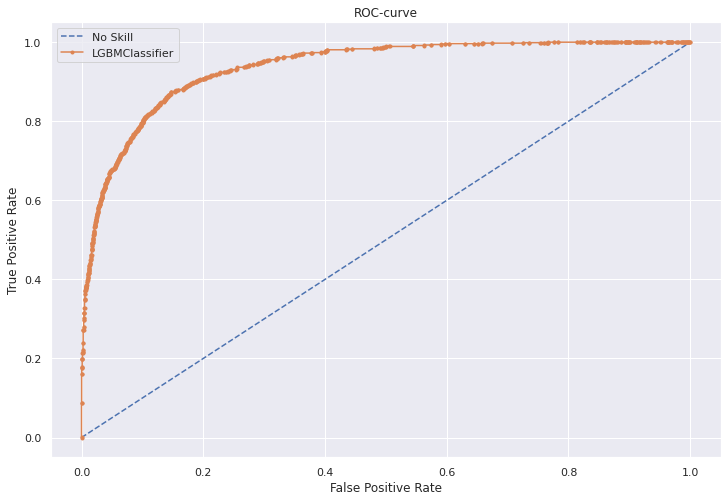

In [67]:
rf = plt.figure(figsize=(12, 8))

plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, _ = roc_curve(y_train, lgbm_model.predict_proba(X_train)[:, 1])
plt.plot(fpr, tpr, marker='.', label='LGBMClassifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend()

plt.show()

- Лучшие гиперпараметры модели: {'subsample_for_bin': 20000, 'num_leaves': 69, 'min_child_samples': 200, 'max_depth': 50, 'learning_rate': 0.1, 'colsample_bytree': 1, 'class_weight': None, 'boosting_type': 'gbdt'}

- Лучшее значение метрики 0.845

Посмотрим на предсказания моделей.

In [68]:
index = ['LogisticRegression',
         'RandomForestClassifier',
         'LGBMClassifier']
data = {'Значение ROC-AUC':[round(lr_model.best_score_, 3),
                            round(rf_model.best_score_, 3),
                            round(lgbm_model.best_score_, 3)]}

tabl_data = pd.DataFrame(data=data, index=index)
tabl_data

,Значение ROC-AUC
LogisticRegression,0.772
RandomForestClassifier,0.832
LGBMClassifier,0.845


# Вывод:
Мы провели разбиение данных на тренировочную и тестовую выборку, так же мы подобрали гиперпараметры для каждой из 3 моделей и построили ROC-кривую. Исходя из значений метрики ROC_AUC лучше всего себя показала модель LGBMClassifier. Значение ROC-AUC для данной модели составило 0.845 что больше требований к задаче. Её лучшие гиперпараметры: {'subsample_for_bin': 20000, 'num_leaves': 69, 'min_child_samples': 200, 'max_depth': 50, 'learning_rate': 0.1, 'colsample_bytree': 1, 'class_weight': None, 'boosting_type': 'gbdt'}. Далее проведем тестирование данной модели на тестовой выборке

# Тестирование модели.

In [69]:
model_test = LGBMClassifier(colsample_bytree=1, max_depth=50, min_child_samples=200,
               num_leaves=69, objective='binary', subsample_for_bin=20000,learning_rate=0.1, random_state=RANDOM,
               class_weight=None, boosting_type='gbdt')
model_test.fit(X_train, y_train)
predicted = model_test.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, predicted)

print('ROC-AUC на тестовой выборке', roc_auc)

ROC-AUC на тестовой выборке 0.8519976213993429


С помощью Shap определим наиболее значимые факторы

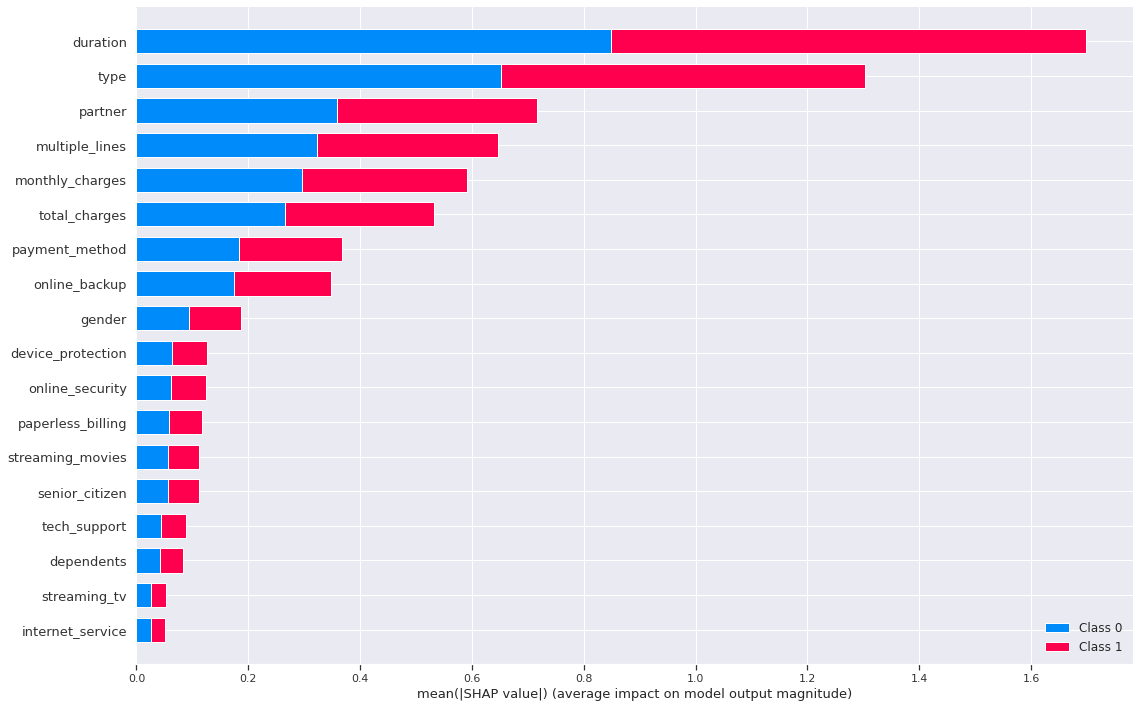

In [70]:
explainer = shap.TreeExplainer(lgbm_model.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(16,10))

Наиболее значимыми являются duration, partner, multiple_lines, online_backup, total_charges, monthly_charges, type.

Посмотрим зависимость предсказания от конкретного признака.

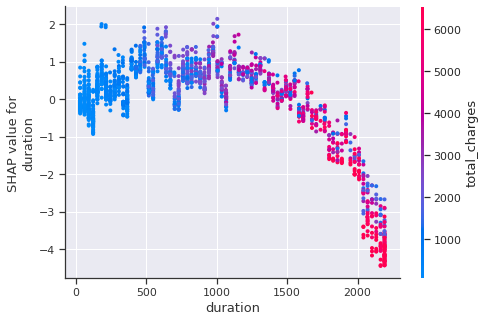

In [71]:
shap.dependence_plot('duration', shap_values[1], X_test)

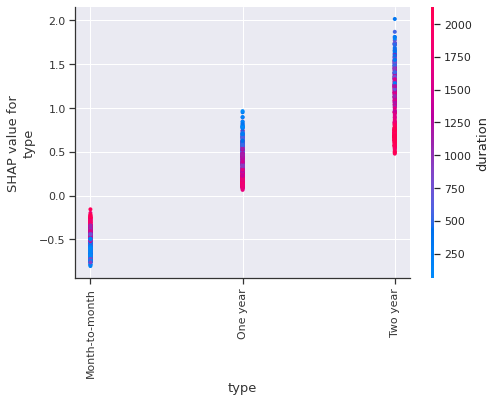

In [72]:
shap.dependence_plot('type', shap_values[1], X_test)

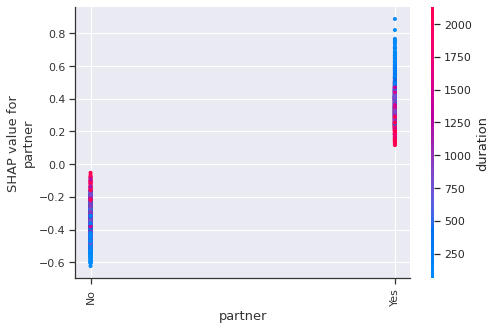

In [73]:
shap.dependence_plot('partner', shap_values[1], X_test)

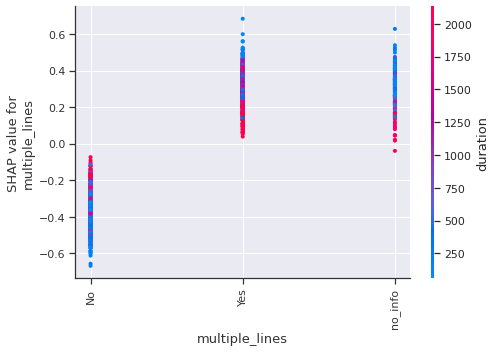

In [74]:
shap.dependence_plot('multiple_lines', shap_values[1], X_test)

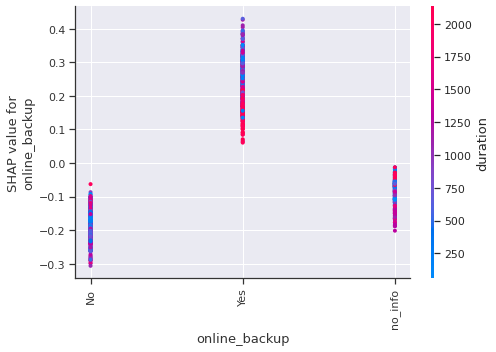

In [75]:
shap.dependence_plot('online_backup', shap_values[1], X_test)

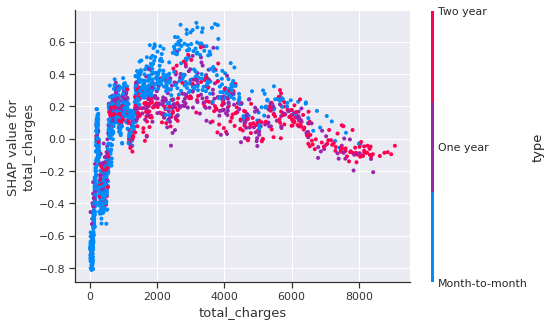

In [76]:
shap.dependence_plot('total_charges', shap_values[1], X_test)

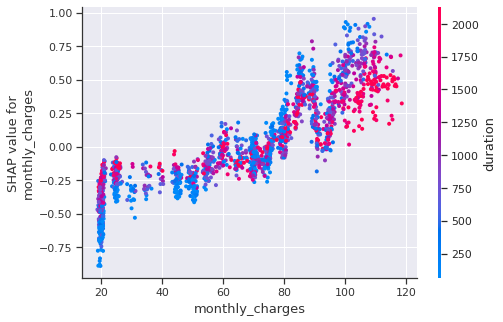

In [77]:
shap.dependence_plot('monthly_charges', shap_values[1], X_test)

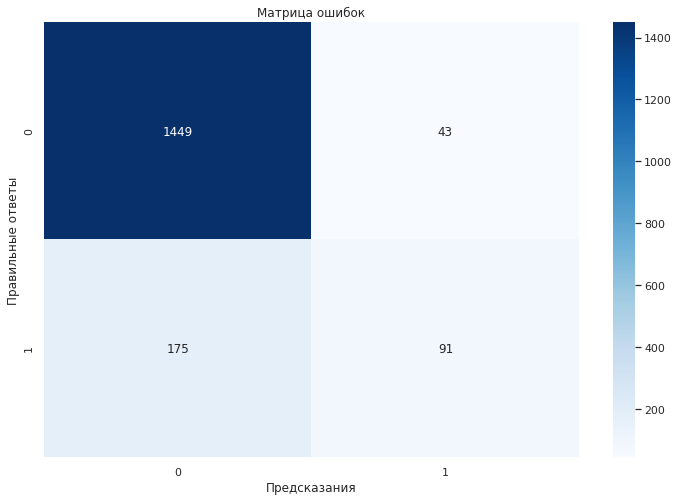

In [78]:
predictions_test = model_test.predict(X_test)
cmatrix = confusion_matrix(y_test, predictions_test)
plt.figure(figsize=(12, 8))
sns.heatmap(cmatrix, 
            annot=True,  
            cmap='Blues', 
            fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
plt.show()

Модель предсказывает довольно хорошо, и не часто ошибается. Я расчитал метрику accuracy она составила 87,5% что довольно много. Я думаю модель имеет такую метрику из-за преобладания одного класса над другим поэтому она почти всегда предсказывает 0 и попадает.

# Вывод:
На тестовой выборке значение ROC-AUC составило 0.832.

Из графиков можно сделать выводы:
- Чем больше длительность договора, тем меньше вероятность его ухода.
- Клиенты у которых много подключенных линий с меньшей вероятностью уходят.
- Клиенты имеющие облочное хранение уходят чаще.
- Чем больше оплата за услуги, тем выше вероятность ухода клиента.
- Клиенты без партнера с большой вероятностю уходят.

## Итоговый вывод

Перед нами стояла задача обучить модель которая будет предсказывать уйдет ли клиент или же нет.

I) В начале работы мы написали план чтобы опираясь на него решить задачу. Разберем поэтапно план и рассмотрим с какими трудностями мы столкнулись.

1) Написать описание и цель проекта,выбрать метрику и ее нижний порог.
- В качестве метрики в данном проекте нами была выбрана ROC-AUC, нижний порог для решения задачи 0.85

2) Загрузили данные. Написали описание к данным.

3) Провести анализ данных.
- Сильную зависимость между total_charges b monthly_charges корреляция Фика 0.71
- total_charges завист от подключенных услуг у абонента.
- Наличие dependents зависит от partner.
- Сильная зависимость есть у подключенных услкг корреляция Фика больше 0.9 следовательно либо пользователь подключает все и сразу либо из-за заинтересованности он подключает дополнительно остальные услуги.
- сильная зависимость между total_charges и duration значение корреляции Пирсона 0.82.
- сильнаяя зависимость между total_charges и monthly_charges значение корреляции Пирсона 0.63.
- Большой отток клиентов которые имеют ежемесячный договор, скорее всего это новые клиенты которые пришли по рекламе или же сами и им просто не понравилось
- Пик прибыли по типу договора на 2 года был в 2014 году, затем пошло на спад.
- Пик прибыли по типу договора на ежемесячные основе в 2018 году.
- Больше всего уходят клиенты получающие электронные чеки.

На отток клиентов сильно влияют:

- payment_method - способ оплаты
- monthly_charges - Ежемесячная оплата
- paperless_billing - способ получения счета
- total_charges - общая сумма оплаты
- type - тип договора

4) Предобработать данные. Найти аномалия, заменить по возможности их. Найти и заменить пропуски. Проверить типы данных.
- Объединили четыре датасета в один датасет по customerID.

- Заполнили пропущенные значения.

- Приводили название столбцов к нижнему регистру.

- Привели название столбцов к snake case.

- Поменяли у некоторых столбцов типы данных.

- Дубликатов не нашли.

- Добавили новые столбцы:
  - churn - клиент ушел или нет (целевой признак).
  - duration - сколько в днях дейсвует договор.
  - services - какое количество сервисов использует клиент.

5) Подготовить данные:

 - Найти целевой признак.
 
 - Объеденить данные.
 
- Подготовили целевой признак.

- Удалили лишнии столбцы(где была дата, чтобы не сильно повлияла на метрику).
 
6) Предобработать и подготовить данные к обучению модели:

- На данном эпапе мы столкнулись с дисбалансом классов. Поэтому решили использовать.

- Для линейной готовили свою выборку (OHE из склерна для категориальных признаков + масштабирование численных)  

- Для деревянной готовили свою выборку (Ordinal для ктегориальных без масштабирования численных)  

- Для бустинга (не кодировали и не масштабировали, отдали "сырую" выборку)  
 
7) Обучить модель:

Для обучения мы взяли 3 модели:

- LogisticRegression

- RandomForestClassifier

- LGBMClassifier


 
8) Проверить модель на тестовой выборке:

 - Предикт на лучшей модели.

9) Выполнить анализ лучшей модели:

- Определили важность признаков.

- Вывели матрицу ошибок.


II) В качестве итоговой модели мы остановились на LGBMClassifier. Её гиперпараметры (colsample_bytree=1, max_depth=50, min_child_samples=200, num_leaves=69, objective='binary', subsample_for_bin=20000, learning_rate=0.1, random_state=140823,
class_weight=None, boosting_type='gbdt'). На тестовой выборке данная модель показала значение ROC-AUC = 0,851. Что является приемлемо для данной задачи.

III) Для данной модели мы использовали признаки приведенные нижне на картинке, они расположенны в порядке убывания важности.

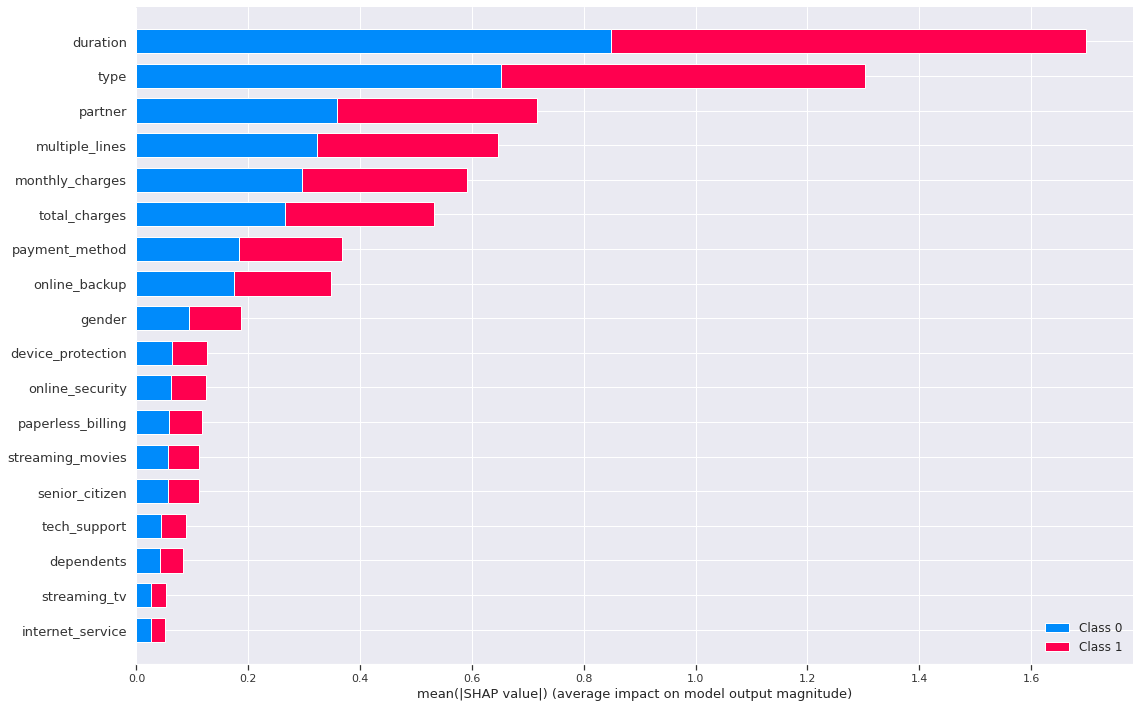